In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import datetime

# Load Dataset

In [16]:
data = pd.read_csv("data/Ethereum.csv")
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,23-Jan-20,$168.30,$168.31,$160.30,$162.93,"$10,396,868,698","$17,824,835,899"
1,24-Jan-20,$162.90,$164.31,$156.75,$163.05,"$10,657,671,162","$17,840,465,424"
2,25-Jan-20,$163.07,$163.23,$158.63,$161.28,"$8,256,956,802","$17,649,296,256"
3,26-Jan-20,$161.18,$168.22,$160.28,$168.08,"$9,261,861,590","$18,394,952,135"
4,27-Jan-20,$168.01,$172.92,$166.90,$170.93,"$11,004,476,145","$18,709,615,891"


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        366 non-null    object
 1   Open        366 non-null    object
 2   High        366 non-null    object
 3   Low         366 non-null    object
 4   Close       366 non-null    object
 5   Volume      366 non-null    object
 6   Market Cap  366 non-null    object
dtypes: object(7)
memory usage: 20.1+ KB


# Change Values

In [18]:
for col in data.columns[1:]:
    data[col] = data[col].map(lambda x:x.replace("$", ""))
    
for col in data.columns[1:]:
    data[col] = data[col].map(lambda x:x.replace(",", ""))

for col in data.columns[1:]:
    data[col] = data[col].map(lambda x:np.float(x))

# Compute Mid price

In [21]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows

In [22]:
# recent 50 days - window size
seq_len = 50
# window size + 1(for prediction)
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data

In [23]:
normalized_data = []
for window in result:
    # devide all data in windows by the first data and minus 1
    # to set the first value 0
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# Split train and test data
# use 90% of data as train
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

# put 50 obs in x_train
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# put 1 obs in y_train
y_train = train[:, -1]

# test is the same as train
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((284, 50, 1), (31, 50, 1))

# Build a Model

In [24]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [27]:
# # run in case of nan values
# x_train = pd.DataFrame(x_train.squeeze(2)).fillna(0.0).values.reshape((x_train.shape[0], x_train.shape[1], 1))
# y_train = pd.DataFrame(y_train).fillna(0.0).values

In [28]:
model.fit(x_train, y_train,
         validation_data = (x_test, y_test),
         batch_size = 10,
         epochs = 20)

Epoch 1/20
29/29 [==============================] - 5s 47ms/step - loss: 0.0415 - val_loss: 0.1506
Epoch 2/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0121 - val_loss: 0.2186
Epoch 3/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0110 - val_loss: 0.0605
Epoch 4/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0087 - val_loss: 0.0636
Epoch 5/20
29/29 [==============================] - 1s 21ms/step - loss: 0.0076 - val_loss: 0.0650
Epoch 6/20
29/29 [==============================] - 1s 18ms/step - loss: 0.0125 - val_loss: 0.0588
Epoch 7/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0069 - val_loss: 0.0691
Epoch 8/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0058 - val_loss: 0.0370
Epoch 9/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0074 - val_loss: 0.0772
Epoch 10/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0060 - val_loss: 0.0288
Epoch 11/

# Prediction

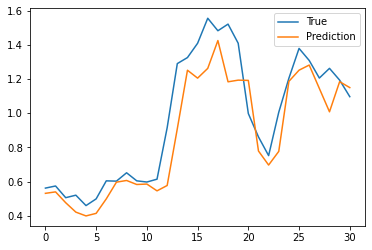

In [29]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()